In [1]:
import dpaleo
import matplotlib.pyplot as plt
import numpy as np

# An implemention of the UCERF3 workflow for NZ-NSHM2022.
### For TVZ, using the Mean Simplified Source Scaling Relation


In [2]:
srcscaling_model = "NZNSHM22_mean" # C = 4.2
outfile_tag = "TVZ"

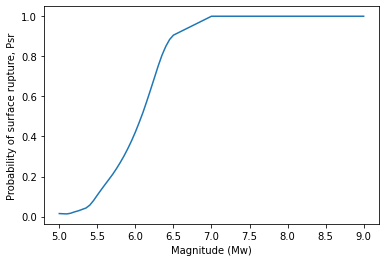

In [3]:
# lets look at the surface rupture model
surfacerupturemodel = 'probability_surface_rupture/NZ_SurfaceRuptureProbability_tvz_bootstrap.csv'
dpaleo.plot_prob_detectsurfrup(model=surfacerupturemodel)  

In [4]:
# this function can go in the dpaleo.py .. anyways
def compute_prob_detectpaleoslip(mag, norm_x =np.linspace(0.00001, 0.5,50), \
                                 srcscaling = "NZNSHM22_mean", detectpaleoslipfactor = 1):
    # get prob of being observble surface-rupture event
    # norm_x in theory can start at 0 but I get a divide by zero warning (not error) ..
    surfacerupturemodel = 'probability_surface_rupture/NZ_SurfaceRuptureProbability_tvz_bootstrap.csv'
    
    P_sr = dpaleo.prob_detectsurfrup(magnitude=mag, model=surfacerupturemodel)

    # get average surface slip
    avg_surfslip = dpaleo.mag2avg_surfslip(magnitude=mag, model=srcscaling)

    # get surface slip profile
    slip_x = dpaleo.slip_profile(avg_surfslip, x_by_RL=norm_x, model="sinesqrt")
    prob_paleo_detect = []

    # slip_x is slip profile
    for ii in range(len(slip_x)): 
        sampledslip, slipprob = dpaleo.prob_slip_profpoint(slip_x[ii], xi=norm_x[ii], \
                                                           model = "GEV", normalized = True)
    
        prob_td_x = [] # prob of being detectable at the paleo trench
        for jj in range(len(sampledslip)):
            # model="wrightwood2013"
            temp = dpaleo.prob_detectpaleoslip(sampledslip[jj], \
                                               prob_sampledslip = slipprob[jj], \
                                               model="wrightwood2013", \
                                               slipfactor = detectpaleoslipfactor)
            prob_td_x.append(temp)
    
        prob_td = sum(prob_td_x)
        prob_paleo_detect.append(prob_td*P_sr)
        
    return (norm_x, prob_paleo_detect, avg_surfslip)

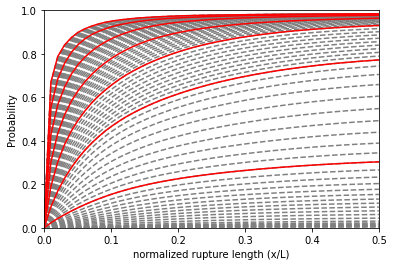

In [5]:
mag = np.arange(5.0, 9.01, 0.05)
for m in mag:
    norm_x, prob_paleo_detect_ww, AD = compute_prob_detectpaleoslip(m, srcscaling = srcscaling_model)
    plt.plot(norm_x, prob_paleo_detect_ww, '--', color = [0.5, 0.5, 0.5])  
    
mag = [6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.01]
#mag = np.arange(5.0, 8.25, 0.05)
for m in mag:
    norm_x, prob_paleo_detect_wws, AD = compute_prob_detectpaleoslip(m, srcscaling = srcscaling_model)
    plt.plot(norm_x, prob_paleo_detect_wws, 'r-')

plt.xlim([0.0, 0.5])
plt.ylim([0.0, 1.0])
plt.xlabel('normalized rupture length (x/L)');
plt.ylabel('Probability');


Figure 6. Probability for detectability of ground-rupture at paleoseismic sites. The lines corresponds to different earthquake magnitudes, and those in red corresponds to magnitudes: Mw 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, and 9.0 in order of the increasing probability.




In [6]:
# let us create a Table similar to Table I2 of Appendix I of UCERF3 report
mag = np.arange(5.5, 9.01, 0.05)

norm_x = np.array([0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.000000001])

print("M AD(M) 0.5 0.45 0.4 0.35 0.3 0.25 0.2 0.15 0.1 0.05 0.0")

out = []
for m in mag:
    tout = []
    norm_x, prob_paleo_detect, AD = compute_prob_detectpaleoslip(m, norm_x = norm_x, \
                                                                srcscaling = srcscaling_model)
    tout.append(round(m,2))
    tout.append(round(AD,3))
    for pi in prob_paleo_detect:
        tout.append(round(pi, 6))
    print(*tout,'    ')
    out.append(tout)

# write out a .txt file
fname = "pdetection_"+outfile_tag+".txt"

# write out a .csv file

import csv 

# open the file in the write mode
f = open(fname, 'w')
# create the csv writer
writer = csv.writer(f, delimiter=' ')
#writer.writerow(['M','AD(M)',0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.0])
# The format as in:
# https://github.com/GNS-Science/nzshm-opensha/blob/main/src/main/resources/paleoRates/pdetection2.txt

writer.writerow([0.0, 0.00,0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.0])

for row in out:
    # write a row to the csv fil
    writer.writerow(row)

# close the file
f.close()
    

M AD(M) 0.5 0.45 0.4 0.35 0.3 0.25 0.2 0.15 0.1 0.05 0.0
5.5 0.333 0.061127 0.059494 0.05737 0.054635 0.051175 0.046711 0.040831 0.03314 0.023465 0.012337 0.0     
5.55 0.353 0.078093 0.076062 0.073403 0.070018 0.065745 0.060235 0.052991 0.043376 0.031035 0.016474 0.0     
5.6 0.374 0.095464 0.09303 0.089859 0.085861 0.080778 0.074279 0.065718 0.054216 0.039205 0.021041 0.0     
5.65 0.396 0.11324 0.110417 0.106752 0.10212 0.096279 0.088808 0.078976 0.065703 0.047979 0.02606 0.0     
5.7 0.42 0.132065 0.128849 0.124674 0.119364 0.112761 0.104319 0.093221 0.078124 0.057654 0.031675 0.0     
5.75 0.445 0.153369 0.149697 0.144927 0.138947 0.131426 0.121909 0.109403 0.092328 0.068861 0.038331 0.0     
5.8 0.471 0.17716 0.173002 0.167629 0.160835 0.152349 0.141626 0.127608 0.108448 0.081719 0.04605 0.0     
5.85 0.499 0.203499 0.198796 0.192701 0.185057 0.17557 0.163558 0.147889 0.126458 0.096261 0.054994 0.0     
5.9 0.528 0.233201 0.227902 0.221049 0.212457 0.201734 0.188336 0.170887 0.14